<h1>Second Midterm</h1>

Alessia De Ponti (599725) <br>
Assignment 1

In [1]:
from hmmlearn import hmm 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

The following code has been written by me. <br>
This notebook can be found on my [GitHub](https://github.com/depoale/ispr.git) aswell.

<h3> Data Preparation

This dataset contains **13 months of hourly data**. <br>
A total of **9357 samples** are avaliable for each of the 15 sensors.

In [2]:
df = pd.read_csv("../air+quality/AirQualityUCI.csv", sep=';') 
df.dropna(inplace=True)     # Drop empty rows

We are interested in analysing a single column of this dataset, corrisponding to a sensor.<br>
Namely we choose the `PT08.S3(NOx)` sensor. <br>

In [3]:
x = df['PT08.S3(NOx)'].to_numpy().reshape(-1,1)

There are a few missing values:

In [4]:
len(np.where(x == -200)[0])

366

Missing values are replaced by the mean of the hour before and after. <br>
If these values are missing aswell, the value at the same time a day before is used. 

In [5]:
for count, elem in enumerate(x):
    if elem == -200:
        if x[count+1] !=-200:
            x[count] =(x[count-1] + x[count+1])/2
        else :
            x[count] = x[count - 24]

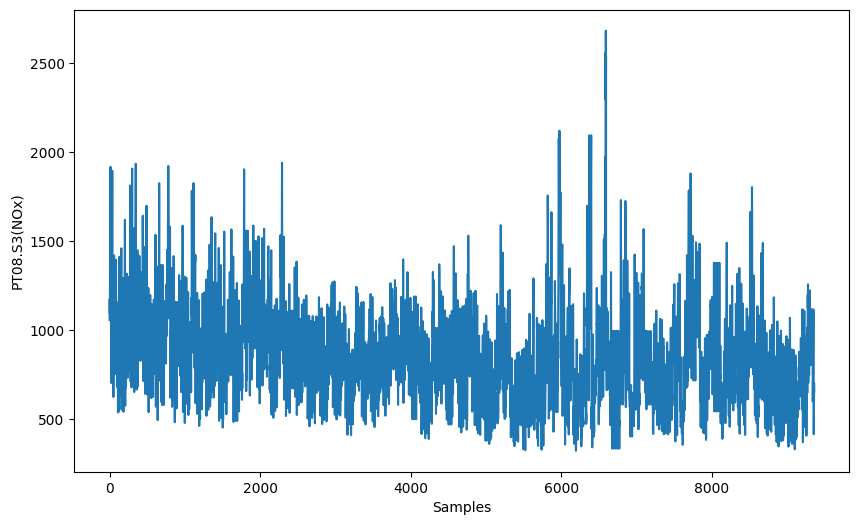

In [6]:
samples = np.linspace(1., len(x), len(x))
plt.figure(figsize = (10, 6))
plt.plot(samples, x)
plt.xlabel('Samples')
plt.ylabel('PT08.S3(NOx)')
plt.show()

<h3> Dataset Split

The dataset spans 13 months so we will use:
* 5 months for *training*
* 5 months for *validation* 
* 3 months as *test* set <br>
  
The training and the validation sets will be used for **model selection** (varying the *number of hidden states* and the *emission distribution*). <br>
The best model will be evalutated on the test set. The optimal hidden state assignement will be computed both with the **Viterbi algorithm** and the **hidden state posterior**.

In [7]:
month = 24*30     # number of samples per month (24 hours * 30 days)

x_train = x[: 5*month]
x_val = x[5*month : 10*month]
x_test = x[10*month :]

<h3> Model Selection

In [8]:
def get_model(x_train, emission, n):
    """
    Trains and return the HMM.

    :param x_train:         training data
    :param emission:        emission distribution (either gaussian or gaussian mixture)
    :param n:               number of hidden states
    """
    
    if emission == 'gaussian':
        model = hmm.GaussianHMM(n_components = n, random_state = 17, n_iter = 50)

    elif emission == 'mixture':
        model = hmm.GMMHMM(n_components = n, n_mix = 3, random_state = 17, n_iter = 50)

    model.fit(x_train)

    return model

The performances of the different models are assessed using the **BIC score** (Bayesian Information Criterion):  
$BIC = n*log(len(x))-2*log( p(x|\hat{\theta}, M))$  
where *n* is the number of hidden states, $x$ is the time series, $M$ is the model and $\hat{\theta}$ the model parameters.  
Therefore $p(x|\hat{\theta}, M)$ is the maximised value of the likelihood function for the model $M$.

The best model will be chosen among: two different emission functions (**gaussian** and **gaussian mixture**) and a number of **hidden states** varying between 1 and 20.

In [9]:
tr_score_g=[]
val_score_g = []
tr_score_m=[]
val_score_m = []

for i in range(1, 21):
    # Gaussian emission function
    model_g = get_model(x_train, 'gaussian', i)
    tr_score_g.append(model_g.bic(x_train))
    val_score_g.append(model_g.bic(x_val))
    
    # Gaussian mixture emission functrion
    model_m = get_model(x_train, 'mixture', i)
    tr_score_m.append(model_m.bic(x_train))
    val_score_m.append(model_m.bic(x_val)) 

Let's plot the results of the training (solid line) and validation (dashed line) in terms of the BIC score.

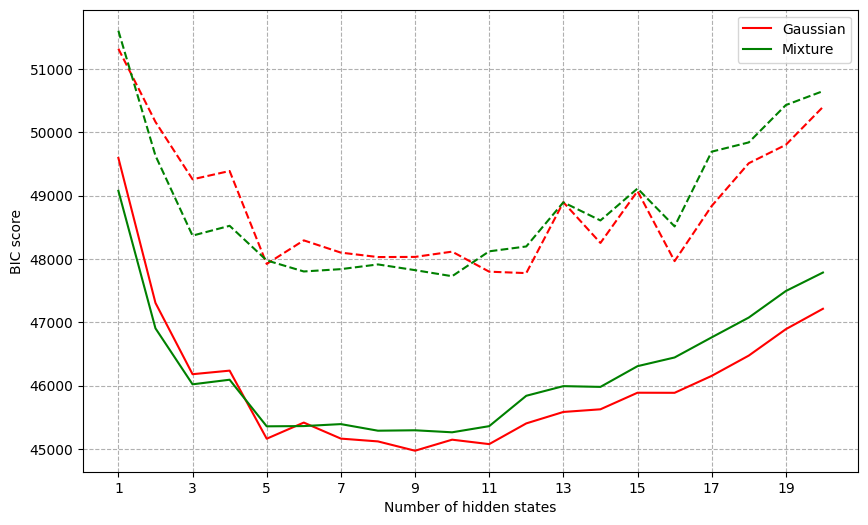

In [54]:
plt.figure(figsize=(10,6))

# Gaussian emission function
plt.plot(range(1,len(tr_score_g)+1), tr_score_g,color = 'r', linestyle ='solid', label = 'Gaussian')
plt.plot(range(1, len(val_score_g)+1), val_score_g,color = 'r', linestyle ='dashed')

# Gaussian mixture emission function
plt.plot(range(1, len(tr_score_m)+1), tr_score_m,color = 'green', linestyle ='solid', label = 'Mixture')
plt.plot(range(1, len(val_score_m)+1), val_score_m,color = 'green', linestyle ='dashed')

plt.xticks(range(1,21,2))
plt.xlabel('Number of hidden states')
plt.ylabel('BIC score')
#plt.grid(linestyle='--')
#plt.yticks([])
plt.legend()
plt.show()

The curves are not very smooth (especially the gaussian ones). Nevertheless, we can see for both emission distributions a rapid decline (*n<5*) followed by a small plateu (*5<n<11*), then the penalty term of the BIC score becomes more and more relevant as *n* grows.  
I'd say that the best performing number of hidden states is the one at the beginning of the plateu ($n=5$) for both emission functions, since the presence of a plateu signifies only small changes in the BIC score at the cost of an higher model complexity.  
The best emission function is going to be the gaussian mixture because it is overall smoother and less noisy, especially around the area we are interested in, namely the beninning of the plateu.  
Ultimately, the best performing model is **gaussian mixture emission with n=5**.

<h3> Results

In [11]:
x_test = np.array(x_test)
x_test = x_test.reshape(-1,1)

In [49]:
n = 5
model = get_model(x_train, 'mixture', n)

Firstly we will compute the optimal state assignment on the test set using the **Viterbi algorithm**.

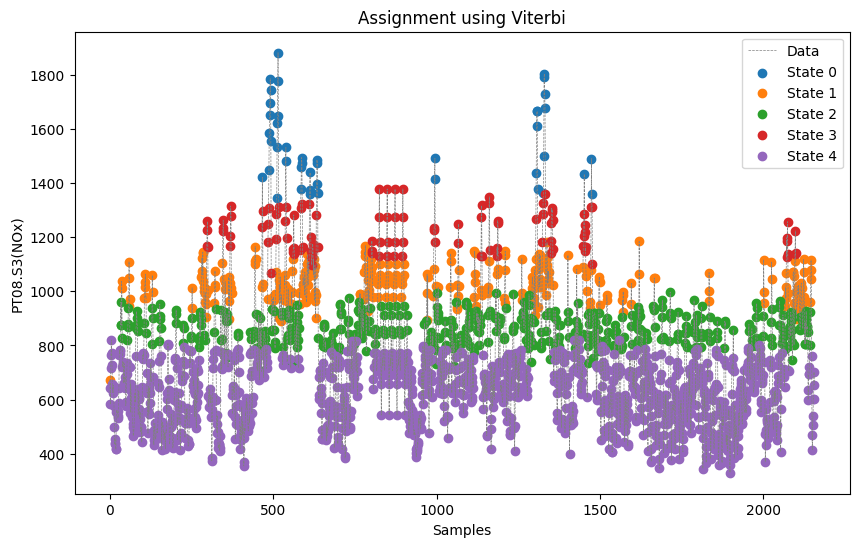

In [55]:
# States predicted by the Viterbi algrithm
viterbi_sequence = model.predict(x_test)

plt.figure(figsize =(10,6))
plt.plot(x_test, color='grey', label='Data', linewidth = 0.5, linestyle = 'dashed')

# Plot the assigned hidden states according to the Viterbi algorithm
for state in range(n):
    state_indices = np.where(viterbi_sequence == state)[0]
    plt.scatter(state_indices, x_test[state_indices], color=f'C{state}', label=f'State {state}')

plt.title('Assignment using Viterbi')
plt.xlabel('Samples')
plt.ylabel('PT08.S3(NOx)')
plt.legend()
plt.show()

Now we assign the hidden state using the **posterior probability**.

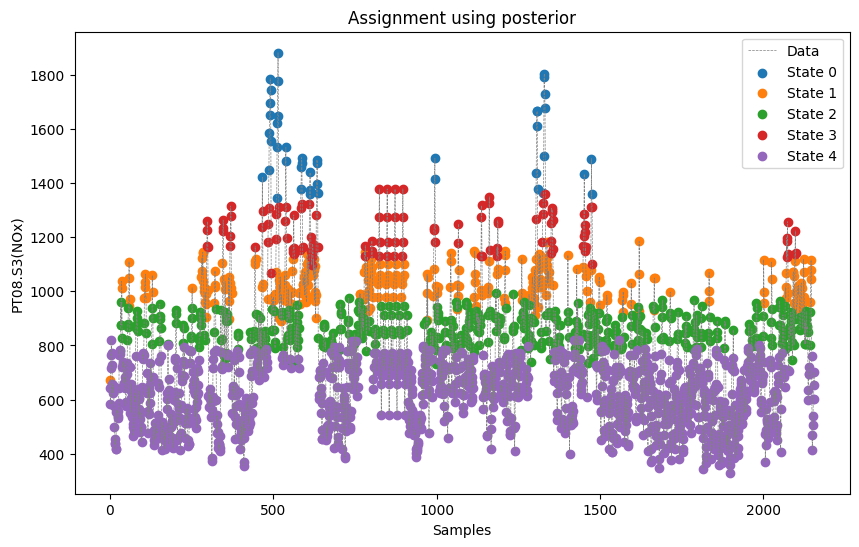

In [51]:
# Calculate the posterior probabilities for each time point
posterior_probabilities = model.predict_proba(x_test)

# Assign each time point to the state with the highest posterior probability
state_assignments = np.argmax(posterior_probabilities, axis=1)

plt.figure(figsize =(10,6))
plt.plot(x_test, color='grey', label='Data', linewidth = 0.5, linestyle = 'dashed')

# Plot the assigned hidden states according to posterior probabilities
for state in range(n):
    state_indices = np.where(state_assignments == state)[0]
    plt.scatter(state_indices, x_test[state_indices], color=f'C{state}', label=f'State {state}')

plt.title('Assignment using posterior')
plt.xlabel('Samples')
plt.ylabel('PT08.S3(NOx)')
plt.legend()
plt.show()

The two plots look very similar.  
Since we are interested in the differences between these two approaches, we mark the points whose assignment is different with a black cross.

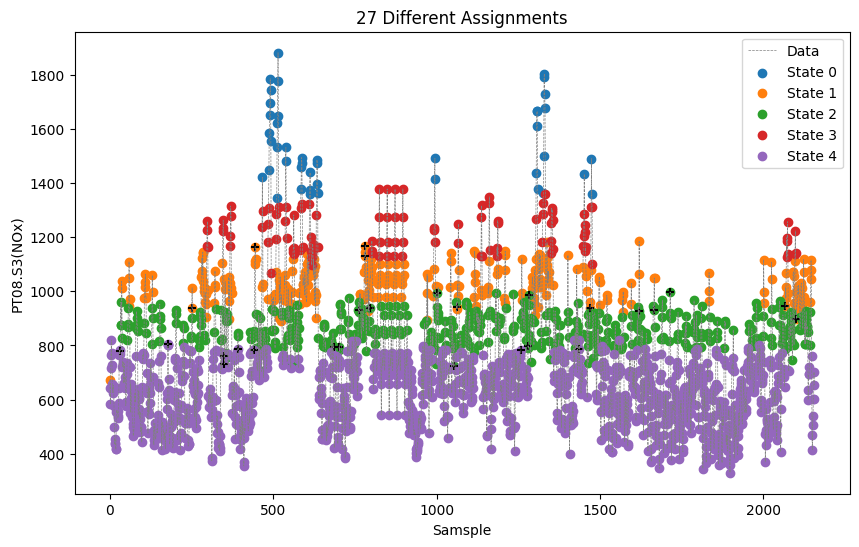

In [52]:
plt.figure(figsize =(10,6))
plt.plot(x_test, color='grey', label='Data', linewidth = 0.5, linestyle = 'dashed')

for state in range(n):
    state_indices = np.where(viterbi_sequence == state)[0]
    plt.scatter(state_indices, x_test[state_indices], color=f'C{state}', label=f'State {state}')
    
# Find indices with different hidden state assignments
different_indices = np.where(state_assignments!=viterbi_sequence)[0]
plt.scatter(different_indices, x_test[different_indices], marker ='+', color = 'black')

plt.title(f'{len(different_indices)} Different Assignments')
plt.xlabel('Samples')
plt.ylabel('PT08.S3(NOx)')
plt.legend()
plt.show()

The state assignments are very consistent: less than 1.3% of test set data has been assigned to different hidden states.  
This means that the HMM model accurately captures the underlying dynamics of the data so much so that hidden state assignments using only the posterior probability are quite precise.

<h3> Conclusion

This method is overall good. For sure having smoother BIC score curves would have made the model selection process less arbitrary.  
Maybe trying other emission distributions or different score functions might help.  
Nevertheless the results on the test set are very satisfactory.